In [1]:
import os
import sys
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import json
import random
%matplotlib inline

from dnc.dnc import DNC
from recurrent_controller import RecurrentController
from generate_data import generate_data, bfs_shortest_path

/Users/YumaKajihara/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/YumaKajihara/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Run Trained Model

In [2]:
ckpts_dir = os.path.join(os.path.dirname("__file__"), 'checkpoints')

tf.reset_default_graph()
session = tf.InteractiveSession()

batch_size = 1
input_size = 52
output_size = 52
sequence_max_length = 140
words_count = 140
word_size = 52
read_heads = 2

ncomputer = DNC(
    RecurrentController,
    input_size,
    output_size,
    sequence_max_length,
    words_count,
    word_size,
    read_heads,
    batch_size
)

ncomputer.restore(session, ckpts_dir, 'graph2-data2-step-1000')

In [3]:
with open("./json/metro_training_data2.json", "r") as f:
    data_dict = json.load(f)
edges = data_dict["edge"]
metro_graph = data_dict["graph"]

In [4]:
output, memory_views = ncomputer.get_outputs()
loss = None
for _k in range(5):
    _theta = _k//2
    tmp_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits_v2(
            logits=output[:,:,(_k*10)+_theta:(_k+1)*10+_theta],
            labels=ncomputer.target_output[:,:,(_k*10)+_theta:(_k+1)*10+_theta],
            name="categorical_loss_"+str(_k+1)
        )
    )
    if loss is None:
        loss = tmp_loss
    else:
        loss = loss + tmp_loss
loss = loss / 5.0

In [6]:
losses = []
matches = []
inputs = []
outputs = []
views = []

for i in range(50):
    
    in_sequences = []
    out_sequences = []
    
    input_data, target_output = generate_data(1, np.array(edges), metro_graph, sequence_max_length)
    l, o, v = session.run([
        loss,
        output,
        memory_views
    ], feed_dict={
        ncomputer.input_data: input_data,
        ncomputer.target_output: target_output,
        ncomputer.sequence_length: np.array(input_data).shape[1]
    })
    
    losses.append(l)
    inputs.append(input_data)
    outputs.append(o)
    views.append(v)
    matches.append(np.allclose(target_output, np.around(o)))

print("Avg. Accuracy: %.4f" % (np.mean(matches)))
print("Avg. Loss: %.4f" % (np.mean(losses)))

Avg. Accuracy: 0.0000
Avg. Loss: 0.0744


In [7]:
best_indx = np.argmin(losses)
print("min : ", losses[best_indx])
best_input, best_output, best_memview = inputs[best_indx], outputs[best_indx], views[best_indx]
worst_indx = np.argmax(losses)
print("max : ", losses[worst_indx])
worst_input, worst_output, worst_memview = inputs[worst_indx], outputs[worst_indx], views[worst_indx]

min :  0.05372269
max :  0.14266567


In [8]:
ww_strip = np.squeeze(best_memview['write_weightings'])
rw_strip = np.squeeze(best_memview['read_weightings'])
free_strip = np.vstack([np.squeeze(best_memview['free_gates'])] )
allocation_strip = np.vstack([np.squeeze(best_memview['allocation_gates'])] )

# Vizualization

In [81]:
def viz_memory_dynamics(memory_view):
    ww_strip = np.squeeze(memory_view['write_weightings'])
    rw_strip = np.squeeze(memory_view['read_weightings'])
    print(rw_strip.shape)
    for i in range(len(rw_strip)):
        print(np.max(ww_strip[i]), np.argmax(ww_strip[i]))
    colored_write = np.zeros((ww_strip.shape[0], ww_strip.shape[1], 3))
    colored_read = np.zeros((rw_strip.shape[0], rw_strip.shape[1], 3))
    for i in range(ww_strip.shape[0]):
        for j in range(ww_strip.shape[1]):
            for k in range(rw_strip.shape[2]):
                colored_read[i, j] = colored_read[i, j] + [rw_strip[i][j][k]*8., 0., 0.]
            colored_write[i, j] = [0., ww_strip[i,j]*100., 0.]
#     plt.figure(figsize=(40, 5))
#     plt.imshow(np.transpose(colored_write + colored_read, [1, 0, 2]), interpolation='nearest')
#     plt.show()

In [82]:
viz_memory_dynamics(best_memview)

(391, 500, 4)
0.07807633 0
0.042720422 2
0.049308147 5
0.017846838 9
0.015189513 13
0.01779857 17
0.016498702 21
0.038359746 25
0.022733904 29
0.031519882 34
0.016058017 38
0.023608146 42
0.025955427 33
0.019902496 50
0.02110125 55
0.031371556 60
0.021235704 65
0.013034301 70
0.024709117 75
0.015372641 80
0.049787406 85
0.023807958 91
0.019234193 96
0.021731084 101
0.01885752 12
0.024159772 74
0.021128021 109
0.011891537 114
0.024104232 119
0.015611529 124
0.029909382 8
0.030140113 129
0.009777927 135
0.024205651 140
0.020222738 146
0.02301732 152
0.029864164 158
0.023202818 164
0.016513448 170
0.030239316 176
0.01926233 182
0.027240492 188
0.018816313 194
0.024650386 200
0.024963716 207
0.01950787 213
0.021487594 219
0.017093178 227
0.015794989 233
0.018381996 239
0.016784437 246
0.016488496 252
0.017425425 258
0.025278062 264
0.013167121 271
0.01750232 277
0.01820033 283
0.02074882 289
0.021203673 295
0.015998397 301
0.017095385 308
0.029007807 315
0.020540517 322
0.014420248 328
0.0

In [56]:
def vizualize_op(input_data, dnc_output, memory_view):
    fig = plt.figure(figsize=(20, 15))
    gs = gridspec.GridSpec(52, 1, hspace=0)
    
    ww_strip = np.squeeze(memory_view['write_weightings'])
    rw_strip = np.squeeze(memory_view['read_weightings'])
    colored_write = np.zeros((ww_strip.shape[0], ww_strip.shape[1], 3))
    colored_read = np.zeros((rw_strip.shape[0], rw_strip.shape[1], 3))
    for i in range(ww_strip.shape[0]):
        for j in range(ww_strip.shape[1]):
            for k in range(rw_strip.shape[2]):
                colored_read[i, j] = colored_read[i, j] + [rw_strip[i][j][k]*2., 0., 0.]
            colored_write[i, j] = [0., ww_strip[i,j]*3., 0.]
    
    free_strip = np.vstack([np.squeeze(memory_view['free_gates'])])
    allocation_strip = np.vstack([np.squeeze(memory_view['allocation_gates'])])
    write_strip = np.vstack([np.squeeze(memory_view['write_gates'])])
    e_vector = np.vstack([np.squeeze(memory_view['erase_vectors'])])
    
    iax = plt.subplot(gs[0:5, 0])
    oax = plt.subplot(gs[7:12, 0])
    memax = plt.subplot(gs[14:24, 0])
    fax = plt.subplot(gs[26:31, 0])
    aax = plt.subplot(gs[32:37, 0])
    wax = plt.subplot(gs[38:43, 0])
    uax = plt.subplot(gs[44:, 0])
    
    iax.grid(True, color='gray')
    oax.grid(True, color='gray')
    memax.grid(True, color='gray', axis='x')
    fax.grid(True, color='gray')
    aax.grid(True, color='gray')
    uax.grid(True, color='gray', axis='x')
    
    iax.imshow(np.squeeze(np.array(input_data).T), cmap=plt.cm.gray, interpolation='nearest')
    iax.set_ylabel("Inputs")
    iax.set_yticks([])
    
    oax.imshow(np.squeeze(dnc_output.T), cmap=plt.cm.gray, interpolation='nearest')
    oax.set_ylabel("Outputs")
    oax.set_yticks([])
    
    memax.imshow(np.transpose(colored_write + colored_read, [1, 0, 2]), interpolation='nearest')
    memax.set_ylabel("Memory Location")
#     write_legend = mpatches.Rectangle((1,1), 1, 1, color='green', label='Write Head')
#     read_legend = mpatches.Rectangle((1,1), 1, 1, color='red', label='Read Head')
#     memax.legend(bbox_to_anchor=(0.21, -0.1), handles=[write_legend, read_legend])
    
    fax.imshow(free_strip.T, cmap=plt.cm.gray, interpolation='nearest')
    fax.set_ylabel("Free Gate")
    fax.set_yticks([])
    
    aax.imshow(allocation_strip, cmap=plt.cm.gray, interpolation='nearest')
    aax.set_ylabel("Alloc. Gate")
    aax.set_yticks([])
    
    wax.imshow(write_strip, cmap=plt.cm.gray, interpolation='nearest')
    wax.set_ylabel("Write. Gate")
    wax.set_yticks([])
    
    uax.imshow(np.squeeze(memory_view['usage_vectors'].T), cmap=plt.cm.gray, interpolation='nearest')
    uax.set_ylabel("Memory Locations Usage")
    uax.set_xlabel("Time")
    plt.show()
    
    plt.figure(figsize=(5, 10))
    plt.imshow(e_vector.T, cmap=plt.cm.gray, interpolation='nearest')
    plt.show()

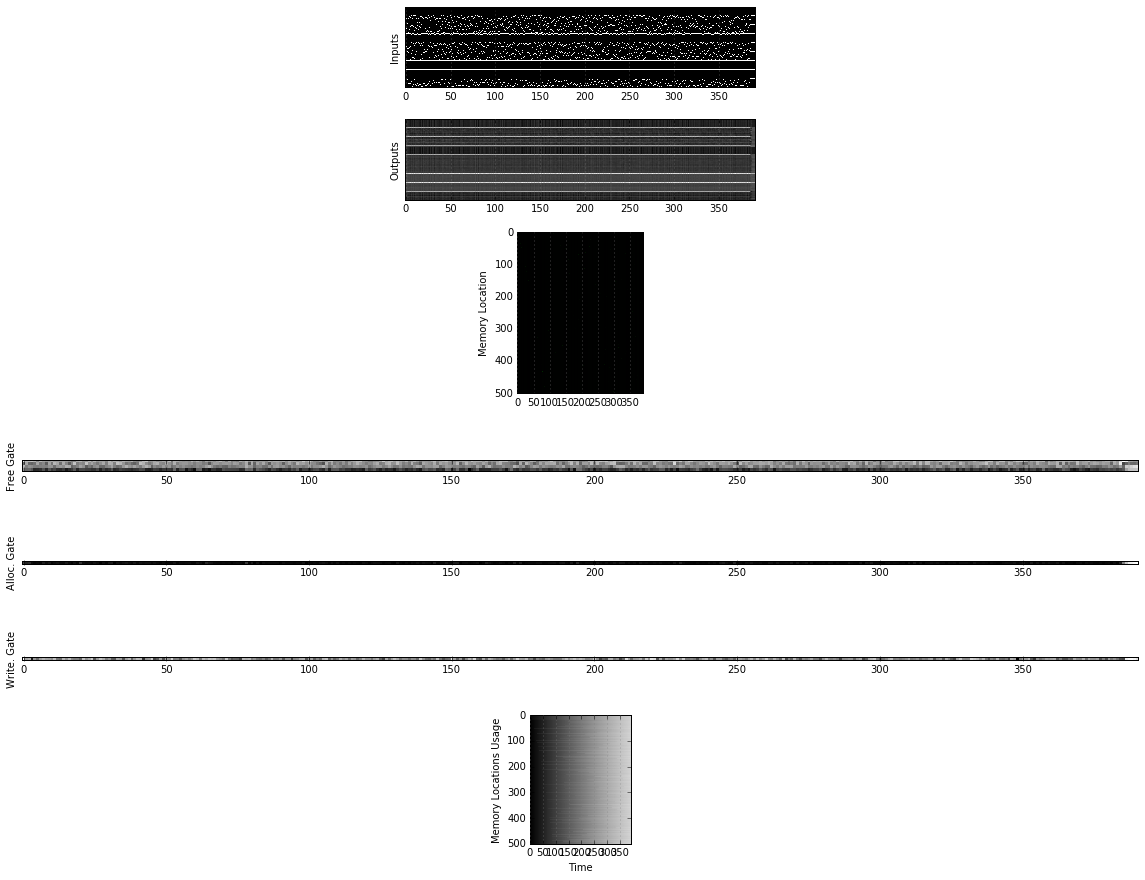

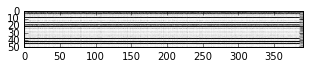

In [57]:
vizualize_op(best_input, best_output, best_memview)

(140, 140, 52)
0.54641306 -0.48724845
1.7443743 -1.5085001
2.4706833 -2.0544224
2.9279795 -2.3971126
2.9384937 -2.405599
2.9607108 -2.414013
3.0922027 -2.544236
3.1030388 -2.553024
3.1135151 -2.5612435
3.1243215 -2.5699654
3.1352844 -2.5788984
3.145463 -2.5868578
3.1561859 -2.5957296
3.167147 -2.6046855
3.1780047 -2.6135492
3.1881812 -2.6214979
3.1986194 -2.629932
3.209623 -2.639129
3.2204945 -2.6481543
3.2314458 -2.6572578
3.241963 -2.665642
3.252641 -2.6744163
3.2631671 -2.6832054
3.2739224 -2.6922886
3.2847881 -2.7013452
3.295771 -2.7103992
3.306608 -2.7193406
3.3175588 -2.7286034
3.3280325 -2.7374377
3.3385868 -2.7462504
3.348767 -2.7547596
3.3590739 -2.7633548
3.3686628 -2.77101
3.3789036 -2.7796054
3.3891773 -2.7882802
3.3997679 -2.7972312
3.4100862 -2.805848
3.4208307 -2.8151548
3.4305987 -2.823217
3.441128 -2.8325806
3.4518356 -2.8419807
3.4625072 -2.8511035
3.4731932 -2.860436
3.483637 -2.8696382
3.4930813 -2.8776944
3.5032763 -2.8866913
3.5132525 -2.895349
3.5235307 -2.904752

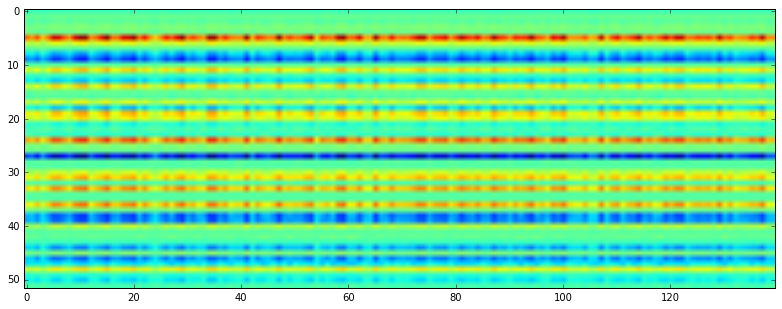

In [23]:
mem_mats = best_memview["memory_matrix"][0]
print(mem_mats.shape)
fig = plt.figure(figsize=(20, 5))
ims = []
# mem_mats.shape[0]
for i in range(mem_mats.shape[0]):
    im = plt.imshow(mem_mats[i].T, animated=True)
    ims.append([im])
    print(np.max(mem_mats[i]), np.min(mem_mats[i]))
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
ani.save('memory.mp4', writer="ffmpeg")
plt.show()

(140, 140, 140)
0.0 0.0
0.21245183 0.0
0.31871578 0.0
0.36925048 0.0
0.38256955 0.0
0.38091278 0.0
0.38355297 0.0
0.38286397 0.0
0.3812098 0.0
0.37947592 0.0
0.37773713 0.0
0.3760069 0.0
0.37430716 0.0
0.3725641 0.0
0.37085024 0.0
0.36911997 0.0
0.36741206 0.0
0.3656722 0.0
0.3639729 0.0
0.36225557 0.0
0.36055785 0.0
0.35887074 0.0
0.3571449 0.0
0.3554338 0.0
0.35372218 0.0
0.35201475 0.0
0.35027 0.0
0.3485603 0.0
0.34684125 0.0
0.3451334 0.0
0.3434758 0.0
0.34179375 0.0
0.34016556 0.0
0.3385041 0.0
0.33683556 0.0
0.33520332 0.0
0.3335452 0.0
0.33187538 0.0
0.33020315 0.0
0.3285465 0.0
0.3268547 0.0
0.3251916 0.0
0.323516 0.0
0.32187322 0.0
0.32018247 0.0
0.31852707 0.0
0.31686452 0.0
0.3152195 0.0
0.31357098 0.0
0.31187776 0.0
0.31020874 0.0
0.30858886 0.0
0.30690536 0.0
0.30521184 0.0
0.3035314 0.0
0.3018525 0.0
0.30018505 0.0
0.2985312 0.0
0.29687274 0.0
0.2951796 0.0
0.29351863 0.0
0.29180756 0.0
0.29010123 0.0
0.28844264 0.0
0.28674573 0.0
0.2850926 0.0
0.283452 0.0
0.28174716 0.0

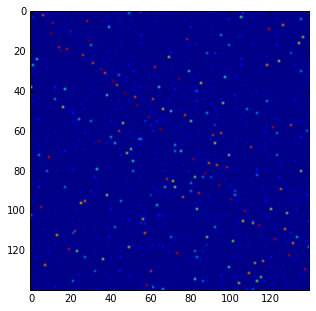

In [24]:
mem_mats = best_memview["link_matrix"][0]
print(mem_mats.shape)
fig = plt.figure(figsize=(20, 5))
ims = []
# mem_mats.shape[0]
for i in range(mem_mats.shape[0]):
    im = plt.imshow(mem_mats[i].T, animated=True)
    ims.append([im])
    print(np.max(mem_mats[i]), np.min(mem_mats[i]))
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
ani.save('link_matrix.mp4', writer="ffmpeg")
plt.show()

In [ ]:
mem_mats = best_memview["link_matrix"][0]
print(mem_mats.shape)
fig = plt.figure(figsize=(20, 5))
ims = []
# mem_mats.shape[0]
for i in range(mem_mats.shape[0]):
    im = plt.imshow(mem_mats[i].T, animated=True)
    ims.append([im])
    print(np.max(mem_mats[i]), np.min(mem_mats[i]))
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
ani.save('link_matrix.mp4', writer="ffmpeg")
plt.show()

In [13]:
def convert_from_onehot(_input):
    i1 = str(np.argmax(_input[:10])) + str(np.argmax(_input[10:20]))
    i2 = str(np.argmax(_input[21:31])) + str(np.argmax(_input[31:41]))
    i3 = str(np.argmax(_input[42:52]))
    print(i1 + " " + i2 + " " + i3)


def convert_one_hot(_arr):
    out_list = []
    for idx, i in enumerate(_arr):
        if idx < 2:
            str_i = "{0:02d}".format(i)
            for char_i in str_i:
                one_hot_char_i = np.eye(10)[[int(char_i)]].tolist()[0]
                out_list.extend(one_hot_char_i)
            out_list.append(0)
        else:
            one_hot_char_i = np.eye(10)[[i]].tolist()[0]
            out_list.extend(one_hot_char_i)
    return out_list

In [27]:
start_id, goal_id = random.sample(range(1, 141), 2)
bfs_shortest_path(metro_graph, start_id, goal_id)

[82, 115, 32, 11, 5, 78, 108, 92, 101]

In [13]:
input_data, target_output = generate_data(1, np.array(edges), metro_graph, sequence_max_length)

In [12]:
print(len(input_data[0]))
for i in range(len(input_data[0])):
    convert_from_onehot(input_data[0][i])

140


ValueError: attempt to get argmax of an empty sequence

In [15]:
for i in range(len(target_output[0])):
    convert_from_onehot(target_output[0][i])

000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 000 000
000 

In [14]:
for i in range(len(inputs[best_indx][0])):
    convert_from_onehot(inputs[best_indx][0][i])

08 01 6
35 28 8
35 06 8
22 13 7
06 31 3
06 38 6
25 18 3
18 24 7
22 20 1
24 18 7
34 26 4
08 06 6
24 16 6
13 22 7
21 36 4
06 08 6
09 19 1
36 21 4
19 27 1
21 36 1
19 09 1
22 29 7
02 21 5
29 18 7
11 37 7
23 39 2
05 19 2
33 17 1
21 02 5
39 02 2
19 10 3
23 08 2
10 06 3
19 05 2
02 15 4
17 27 1
02 36 4
16 24 6
06 10 3
24 16 8
37 11 7
17 33 1
31 18 3
27 17 1
01 08 6
18 29 7
15 02 4
22 25 3
38 16 6
33 21 1
21 33 5
22 07 5
28 35 8
10 12 2
26 34 4
32 13 7
18 25 3
19 03 2
10 19 3
08 23 2
20 36 1
34 21 4
36 21 1
07 22 5
20 22 1
27 19 1
07 02 5
37 24 7
21 33 1
12 10 2
33 21 5
30 16 8
12 33 5
38 06 6
19 05 3
04 24 8
30 06 8
06 35 8
02 07 5
05 19 3
25 22 3
16 38 6
12 08 2
22 14 1
16 24 8
03 10 2
16 30 8
24 04 8
18 31 3
29 22 7
02 39 2
38 12 5
31 06 3
24 37 7
13 32 7
03 19 2
21 34 4
33 12 5
39 23 2
08 12 2
12 38 5
36 02 4
10 03 2
14 22 1
36 20 1
06 30 8
23 01 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0


In [15]:
for i in range(len(outputs[best_indx][0])):
    convert_from_onehot(outputs[best_indx][0][i])

00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
32 12 5
12 12 5
00 00 5
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0


In [16]:
for i in range(len(target_output[0])):
    convert_from_onehot(target_output[0][i])

00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
30 06 8
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0


In [17]:
for i in range(len(input_data[0])):
    convert_from_onehot(input_data[0][i])

06 10 3
24 18 7
36 20 1
08 06 6
21 33 1
29 22 7
09 19 1
33 17 1
38 12 5
22 20 1
34 21 4
06 30 8
12 38 5
19 05 2
33 21 1
28 35 8
22 29 7
16 24 6
07 22 5
24 04 8
03 19 2
31 18 3
33 12 5
03 10 2
02 21 5
19 03 2
35 28 8
06 08 6
10 03 2
22 14 1
05 19 3
25 18 3
20 36 1
37 24 7
18 25 3
21 34 4
39 02 2
06 38 6
19 27 1
33 21 5
22 25 3
12 33 5
32 13 7
05 19 2
02 36 4
19 10 3
11 37 7
37 11 7
18 24 7
23 39 2
36 02 4
08 12 2
27 17 1
24 16 8
16 24 8
13 32 7
02 07 5
12 10 2
21 02 5
02 15 4
13 22 7
22 13 7
14 22 1
25 22 3
08 23 2
17 27 1
27 19 1
30 16 8
24 37 7
38 16 6
24 16 6
19 05 3
31 06 3
10 12 2
36 21 4
21 36 1
23 08 2
21 33 5
29 18 7
34 26 4
01 08 6
26 34 4
21 36 4
19 09 1
10 06 3
16 30 8
08 01 6
16 38 6
04 24 8
36 21 1
20 22 1
07 02 5
30 06 8
18 29 7
17 33 1
39 23 2
15 02 4
22 07 5
06 35 8
18 31 3
35 06 8
06 31 3
10 19 3
02 39 2
38 06 6
12 08 2
30 06 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0


In [18]:
for i in range(len(o[0])):
    convert_from_onehot(o[0][i])

00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
32 22 5
12 12 5
00 00 5
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0
00 00 0


In [19]:
best_memview.keys()

dict_keys(['write_gates', 'memory_matrix', 'erase_vectors', 'read_keys', 'write_key', 'read_vectors', 'write_vector', 'free_gates', 'read_weightings', 'allocation_gates', 'read_modes', 'write_weightings', 'usage_vectors', 'link_matrix'])

(1, 391, 50)
0.9165325 18
0.93077296 18
0.93814653 2
0.96373147 40
0.97395825 12
0.96929854 40
0.97022396 40
0.95052075 18
0.9689933 12
0.94938713 12
0.97790617 40
0.9575121 40
0.97532815 40
0.96678716 40
0.9606909 40
0.9642719 40
0.9650792 40
0.97078806 18
0.9579674 40
0.9788088 40
0.95369923 40
0.9726351 2
0.9719368 40
0.970036 40
0.9668838 40
0.9715722 40
0.96989197 18
0.97757965 40
0.96515155 40
0.9765281 40
0.9626818 40
0.9690257 40
0.98279655 40
0.9636633 47
0.97326094 40
0.97315514 40
0.9689719 40
0.969059 40
0.9810626 40
0.96015626 12
0.9667076 18
0.9588777 40
0.9721647 40
0.972818 40
0.97838414 40
0.9680302 36
0.9677086 40
0.97394854 40
0.9747516 40
0.9662788 40
0.9699753 40
0.9697269 40
0.9752901 40
0.9624044 40
0.9833723 40
0.9618043 40
0.9630775 36
0.97495043 40
0.97171146 40
0.9707675 40
0.9752109 18
0.9647028 40
0.96692264 40
0.979599 40
0.95468247 40
0.9725839 40
0.96135426 18
0.9675041 40
0.975179 40
0.97716296 40
0.9674521 40
0.97168565 40
0.96652615 40
0.974535 40
0.9

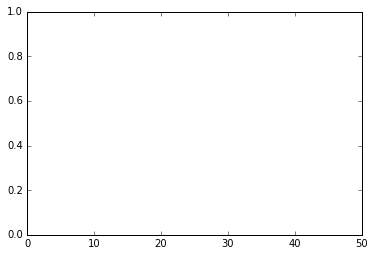

In [86]:
fig = plt.figure()
ims = []
print(best_memview["erase_vectors"].shape)
for i in range(best_memview["erase_vectors"].shape[1]):
    line, = plt.plot(best_memview["erase_vectors"][0][i], "r")
    ims.append([line])
    print(np.max(best_memview["erase_vectors"][0][i]), np.argmax(best_memview["erase_vectors"][0][i]))
ani = animation.ArtistAnimation(fig, ims)
ani.save('erase_vec.mp4', writer="ffmpeg")
plt.show()

(1, 140, 140)
0.396204 0
0.5362183 2
0.59407574 6
0.6213347 11
0.61555994 10
0.6159527 20
0.62254494 15
0.6148557 29
0.60902846 35
0.6089322 41
0.6089019 47
0.5998087 53
0.6087545 59
0.60017985 65
0.60051614 34
0.5887011 74
0.594418 81
0.5895857 87
0.5940925 94
0.5861112 100
0.5829385 107
0.582522 114
0.5712836 122
0.5738623 129
0.5695287 137
0.5670158 58
0.5580925 121
0.5622654 73
0.552314 9
0.5546813 119
0.55782115 19
0.54776955 18
0.5492754 14
0.547437 78
0.5438362 98
0.5503739 5
0.53985494 28
0.53848135 62
0.52478576 91
0.5318068 84
0.52221173 68
0.5252679 110
0.52164924 22
0.52067876 26
0.49815136 31
0.5102048 37
0.506807 43
0.50743294 52
0.5069204 77
0.4934294 93
0.4909244 76
0.48869905 89
0.47892794 125
0.47484878 116
0.47323868 131
0.47326708 109
0.47259957 127
0.46838596 7
0.4598835 126
0.45315486 112
0.44878376 13
0.4427946 136
0.44470015 104
0.44339877 56
0.42702967 46
0.4373328 96
0.4236282 25
0.4117547 124
0.41296342 36
0.41486087 85
0.40688092 71
0.39838883 48
0.415406 16

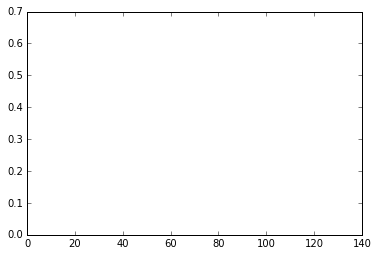

In [20]:
fig = plt.figure()
ims = []
print(best_memview["write_weightings"].shape)
for i in range(best_memview["write_weightings"].shape[1]):
    line, = plt.plot(best_memview["write_weightings"][0][i], "r")
    ims.append([line])
    print(np.max(best_memview["write_weightings"][0][i]), np.argmax(best_memview["write_weightings"][0][i]))
ani = animation.ArtistAnimation(fig, ims)
ani.save('write_weightings.mp4', writer="ffmpeg")
plt.show()

(1, 140, 140, 2)
0.0020972202 272
0.0028102582 0
0.0032525463 4
0.0036710277 0
0.0037805259 4
0.0038519446 4
0.0041690185 4
0.0042683687 4
0.0041882372 4
0.004428881 4
0.00456594 4
0.004278523 22
0.00457021 4
0.0045050005 4
0.004535248 4
0.0042598397 22
0.0043243086 4
0.0044977833 4
0.0046002334 4
0.0046292683 4
0.004519373 4
0.0046332753 4
0.0045064213 22
0.0046087992 4
0.004643577 4
0.0046707965 4
0.0045639053 22
0.004768968 4
0.004719966 4
0.0046477946 22
0.0045866617 22
0.0046431455 4
0.004489744 22
0.0045629675 22
0.004614034 22
0.004887568 4
0.004693964 22
0.0047887038 4
0.0045368536 22
0.004998343 4
0.0049994057 4
0.00499268 4
0.0049438393 168
0.005196984 4
0.004871759 168
0.0049686315 168
0.0049136705 220
0.0050639217 4
0.005132111 74
0.005122049 74
0.005196885 104
0.0052393232 104
0.0052850973 104
0.0051398887 152
0.0052969237 250
0.005345756 250
0.00531189 250
0.0051260376 218
0.0051683187 218
0.005135068 218
0.00517565 218
0.0054404326 218
0.0054136585 218
0.0053377757 218
0

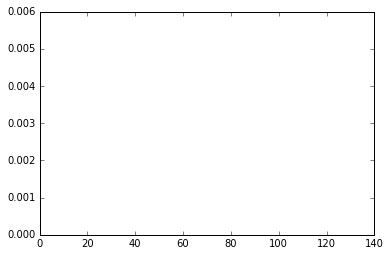

In [22]:
fig = plt.figure()
ims = []
print(best_memview["read_weightings"].shape)
for i in range(best_memview["read_weightings"].shape[1]):
    line1, = plt.plot(np.squeeze(best_memview["read_weightings"][0][i][:].T[0]), "r")
    line2, = plt.plot(np.squeeze(best_memview["read_weightings"][0][i][:].T[1]), "b")
#     line3, = plt.plot(np.squeeze(best_memview["read_weightings"][0][i][:].T[2]), "g")
#     line4, = plt.plot(np.squeeze(best_memview["read_weightings"][0][i][:].T[3]), "y")
    ims.append([line1, line2])
    print(np.max(best_memview["read_weightings"][0][i]), np.argmax(best_memview["read_weightings"][0][i]))
ani = animation.ArtistAnimation(fig, ims)
ani.save('read_weightings.mp4', writer="ffmpeg")
plt.show()

In [98]:
np.squeeze(best_memview["read_weightings"][0][0][:].T[1].shape)

array(500)

(1, 140, 52, 1)
0.42801207 2
0.9050651 32
1.0718559 32
1.2152174 32
1.1887696 32
1.2179619 32
1.2179046 32
1.1751057 32
1.1751157 32
1.2117549 32
1.1186112 32
1.1111772 32
1.1460551 32
1.1400558 32
1.1342093 32
1.1302718 32
1.1178895 32
1.1115644 32
1.0980808 32
1.1287344 32
1.1027399 32
1.1509339 32
1.0777371 32
1.1382978 32
1.1025971 32
1.1375102 32
1.081145 32
1.0918072 32
1.0301216 32
1.0201253 32
1.0436062 32
1.0688323 32
1.0000827 32
1.0258378 32
1.0560513 32
1.0645422 32
1.0453017 32
1.0554523 32
1.0220096 32
1.0366224 32
1.0522892 32
1.0605797 32
1.0796801 32
1.0411619 32
0.9658586 32
1.0415815 32
0.9631708 32
1.0115387 32
1.0375768 32
1.0074279 32
0.98427266 32
0.92954445 32
1.000679 32
0.9164132 32
0.93021685 32
0.97770244 32
0.9634491 32
0.8799109 32
0.9107352 32
0.8692347 32
0.8876583 32
0.86654097 32
0.9216701 32
0.82304764 32
0.80451053 32
0.90274143 32
0.73380816 43
0.8011191 43
0.8354883 43
0.8396672 43
0.79504085 43
0.77798814 20
0.84757733 43
0.7723471 43
0.7862346 43

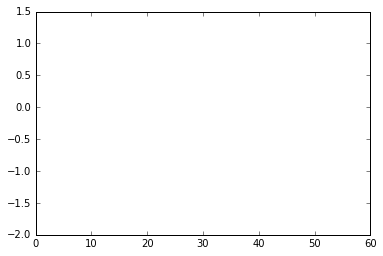

In [25]:
fig = plt.figure()
ims = []
print(best_memview["write_key"].shape)
for i in range(best_memview["write_key"].shape[1]):
    line, = plt.plot(best_memview["write_key"][0][i], "r")
    ims.append([line])
    print(np.max(best_memview["write_key"][0][i]), np.argmax(best_memview["write_key"][0][i]))
ani = animation.ArtistAnimation(fig, ims)
ani.save('write_key.mp4', writer="ffmpeg")
plt.show()

(1, 140, 52)
1.3791183 5
3.2479405 5
4.14123 5
4.68015 5
4.7030005 5
4.7402563 5
4.884294 5
4.844002 5
4.702116 5
4.8289814 5
4.8737087 5
4.541568 5
4.8434563 5
4.7967396 5
4.810504 5
4.4617133 5
4.6143756 5
4.7434516 5
4.776432 5
4.7421546 5
4.594511 5
4.6675253 5
4.4860625 5
4.6059995 5
4.6275287 5
4.6640944 5
4.490554 5
4.615471 5
4.3806157 5
4.427033 5
4.3800135 5
4.358494 5
4.180658 5
4.3457036 5
4.310013 5
4.514988 5
4.3135467 5
4.436945 5
4.037574 5
4.3639307 5
4.32388 5
4.357479 5
4.313277 5
4.296493 5
3.8021874 5
4.1316876 5
4.013803 5
4.1480274 5
4.1947193 5
4.120916 5
4.0481496 5
3.8314407 5
3.903323 5
3.770394 5
3.884217 5
3.8665776 5
3.895495 5
3.740093 5
3.6769347 5
3.620341 5
3.5708547 5
3.7217627 5
3.7263873 5
3.5310771 5
3.3568597 5
3.60758 5
3.0766437 5
3.3894181 5
3.388822 5
3.220314 5
3.3615654 5
3.154827 5
3.3959477 5
3.2032645 5
3.151318 5
3.0566716 5
2.7265382 5
2.953553 5
2.758313 5
2.9841948 5
3.1859794 5
3.260189 5
3.0712328 5
3.2137554 5
3.1861544 5
2.6269746

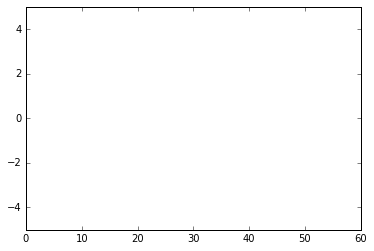

In [27]:
fig = plt.figure()
ims = []
print(best_memview["write_vector"].shape)
for i in range(best_memview["write_vector"].shape[1]):
    line, = plt.plot(best_memview["write_vector"][0][i], "r")
    ims.append([line])
    print(np.max(best_memview["write_vector"][0][i]), np.argmax(best_memview["write_vector"][0][i]))
ani = animation.ArtistAnimation(fig, ims)
ani.save('write_vector.mp4', writer="ffmpeg")
plt.show()

(1, 140, 52, 2)
0.0020112316 10
0.009434552 10
0.020761697 10
0.036893792 10
0.051141664 10
0.066345274 10
0.08883685 10
0.10778764 10
0.12107489 10
0.14643878 10
0.16959046 10
0.1741964 10
0.20512396 10
0.22004668 10
0.24054027 10
0.24011594 10
0.26199406 10
0.2902452 10
0.31530154 10
0.33645597 10
0.34707925 10
0.3732397 10
0.38193816 10
0.40863767 10
0.43046308 10
0.45103967 10
0.4596812 10
0.4987448 10
0.5146549 10
0.52261275 10
0.5325276 10
0.5589275 10
0.5505843 10
0.58147377 10
0.60507625 10
0.65883285 10
0.64991343 10
0.6838695 10
0.6582484 10
0.75035614 10
0.7726504 10
0.7912384 10
0.8028034 10
0.86362493 10
0.8218784 10
0.8625182 10
0.8670466 10
0.9158721 10
0.9445114 10
0.9596388 10
0.9922114 10
1.0187193 10
1.0461411 10
1.0286295 10
1.0795008 10
1.1008294 10
1.1118529 10
1.0889812 10
1.1116254 10
1.1201539 10
1.1471761 10
1.225055 10
1.2325404 10
1.235488 10
1.2633597 10
1.3474734 10
1.2895603 10
1.3521736 10
1.3752532 10
1.3458328 10
1.3854582 10
1.376637 10
1.4006002 10
1

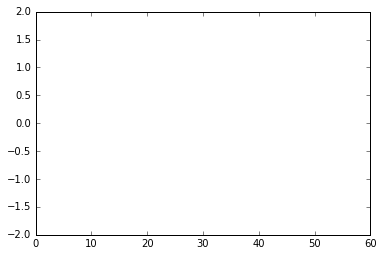

In [28]:
fig = plt.figure()
ims = []
print(best_memview["read_vectors"].shape)
for i in range(best_memview["read_vectors"].shape[1]):
    line1, = plt.plot(np.squeeze(best_memview["read_vectors"][0][i][:].T[0]), "r")
    line2, = plt.plot(np.squeeze(best_memview["read_vectors"][0][i][:].T[1]), "b")
#     line3, = plt.plot(np.squeeze(best_memview["read_weightings"][0][i][:].T[2]), "g")
#     line4, = plt.plot(np.squeeze(best_memview["read_weightings"][0][i][:].T[3]), "y")
    ims.append([line1, line2])
    print(np.max(best_memview["read_vectors"][0][i]), np.argmax(best_memview["read_vectors"][0][i]))
ani = animation.ArtistAnimation(fig, ims)
ani.save('read_vectors.mp4', writer="ffmpeg")
plt.show()

(1, 140, 3, 2)
0.3930735 0
0.44426546 5
0.52761394 5
0.570959 5
0.6042603 5
0.5981447 5
0.59160227 5
0.5897118 5
0.5911537 5
0.5873283 5
0.58132964 5
0.58316386 5
0.57789767 5
0.5813569 5
0.5858772 5
0.5840084 5
0.5750211 5
0.5870438 5
0.57831115 5
0.5829763 5
0.5789415 5
0.5714604 5
0.57452464 5
0.57294333 5
0.57465893 5
0.5781401 5
0.5662649 5
0.56891745 5
0.57420504 5
0.5668649 5
0.56779456 5
0.57024646 5
0.56763756 5
0.5665735 5
0.5609051 5
0.5628386 5
0.5603462 5
0.56124866 5
0.5629628 5
0.5443084 5
0.55513626 5
0.55642694 5
0.55057776 5
0.5532429 5
0.54208034 5
0.5350195 5
0.54855174 5
0.54466844 5
0.53650624 5
0.5519874 5
0.5425323 2
0.5487278 2
0.5567075 2
0.5235806 5
0.56041014 2
0.5581878 2
0.5519532 2
0.519541 5
0.5315137 2
0.52435553 2
0.53527915 2
0.5840931 2
0.566978 2
0.55780345 2
0.570283 2
0.6228566 2
0.5548274 2
0.60408306 2
0.6037711 2
0.56830174 2
0.5942354 2
0.5730454 2
0.5837692 2
0.562259 2
0.5384659 2
0.56485933 2
0.53878134 2
0.53450674 2
0.51581514 2
0.5414324

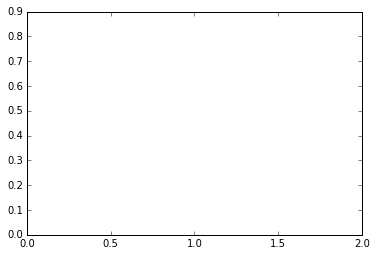

In [29]:
fig = plt.figure()
ims = []
print(best_memview["read_modes"].shape)
for i in range(best_memview["read_modes"].shape[1]):
    line1, = plt.plot(np.squeeze(best_memview["read_modes"][0][i][:].T[0]), "r")
    line2, = plt.plot(np.squeeze(best_memview["read_modes"][0][i][:].T[1]), "b")
#     line3, = plt.plot(np.squeeze(best_memview["read_weightings"][0][i][:].T[2]), "g")
#     line4, = plt.plot(np.squeeze(best_memview["read_weightings"][0][i][:].T[3]), "y")
    ims.append([line1, line2])
    print(np.max(best_memview["read_modes"][0][i]), np.argmax(best_memview["read_modes"][0][i]))
ani = animation.ArtistAnimation(fig, ims)
ani.save('read_modes.mp4', writer="ffmpeg")
plt.show()

In [36]:
best_output[:, :,0:10]

array([[[ 4.555956 , -1.401258 , -1.5771025, ..., -3.5933592,
         -3.3964193, -3.4449055],
        [10.712798 , -3.4399524, -4.0637975, ..., -7.893444 ,
         -7.383495 , -7.485494 ],
        [13.285071 , -4.2244873, -5.20283  , ..., -9.433374 ,
         -8.759423 , -8.780094 ],
        ...,
        [ 8.796528 , -1.9686741, -2.677125 , ..., -8.40971  ,
         -7.2227445, -7.554847 ],
        [ 8.778809 , -1.9601686, -2.6692405, ..., -8.40902  ,
         -7.2227836, -7.556142 ],
        [ 8.762462 , -1.952296 , -2.6619353, ..., -8.408378 ,
         -7.2227955, -7.5573483]]], dtype=float32)

In [37]:
len(edges)

106